# How to edit graph state

!!! tip "Prerequisites"

    * [Human-in-the-loop](../../../concepts/human_in_the_loop)
    * [Breakpoints](../../../concepts/breakpoints)
    * [LangGraph Glossary](../../../concepts/low_level)

Human-in-the-loop (HIL) interactions are crucial for [agentic systems](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#human-in-the-loop). Manually updating the graph state a common HIL interaction pattern, allowing the human to edit actions (e.g., what tool is being called or how it is being called).

We can implement this in LangGraph using a [breakpoint](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/breakpoints/): breakpoints allow us to interrupt graph execution before a specific step. At this breakpoint, we can manually update the graph state and then resume from that spot to continue.

!!! note "Working with Tool Calls"
    When editing tool calls in the state, it's important to maintain proper message structure. Some LLM providers (like Anthropic) require that each `tool_use` message is immediately followed by a corresponding `tool_result` message. When updating tool calls before they are executed, make sure to properly update the AIMessage with the modified tool call information.

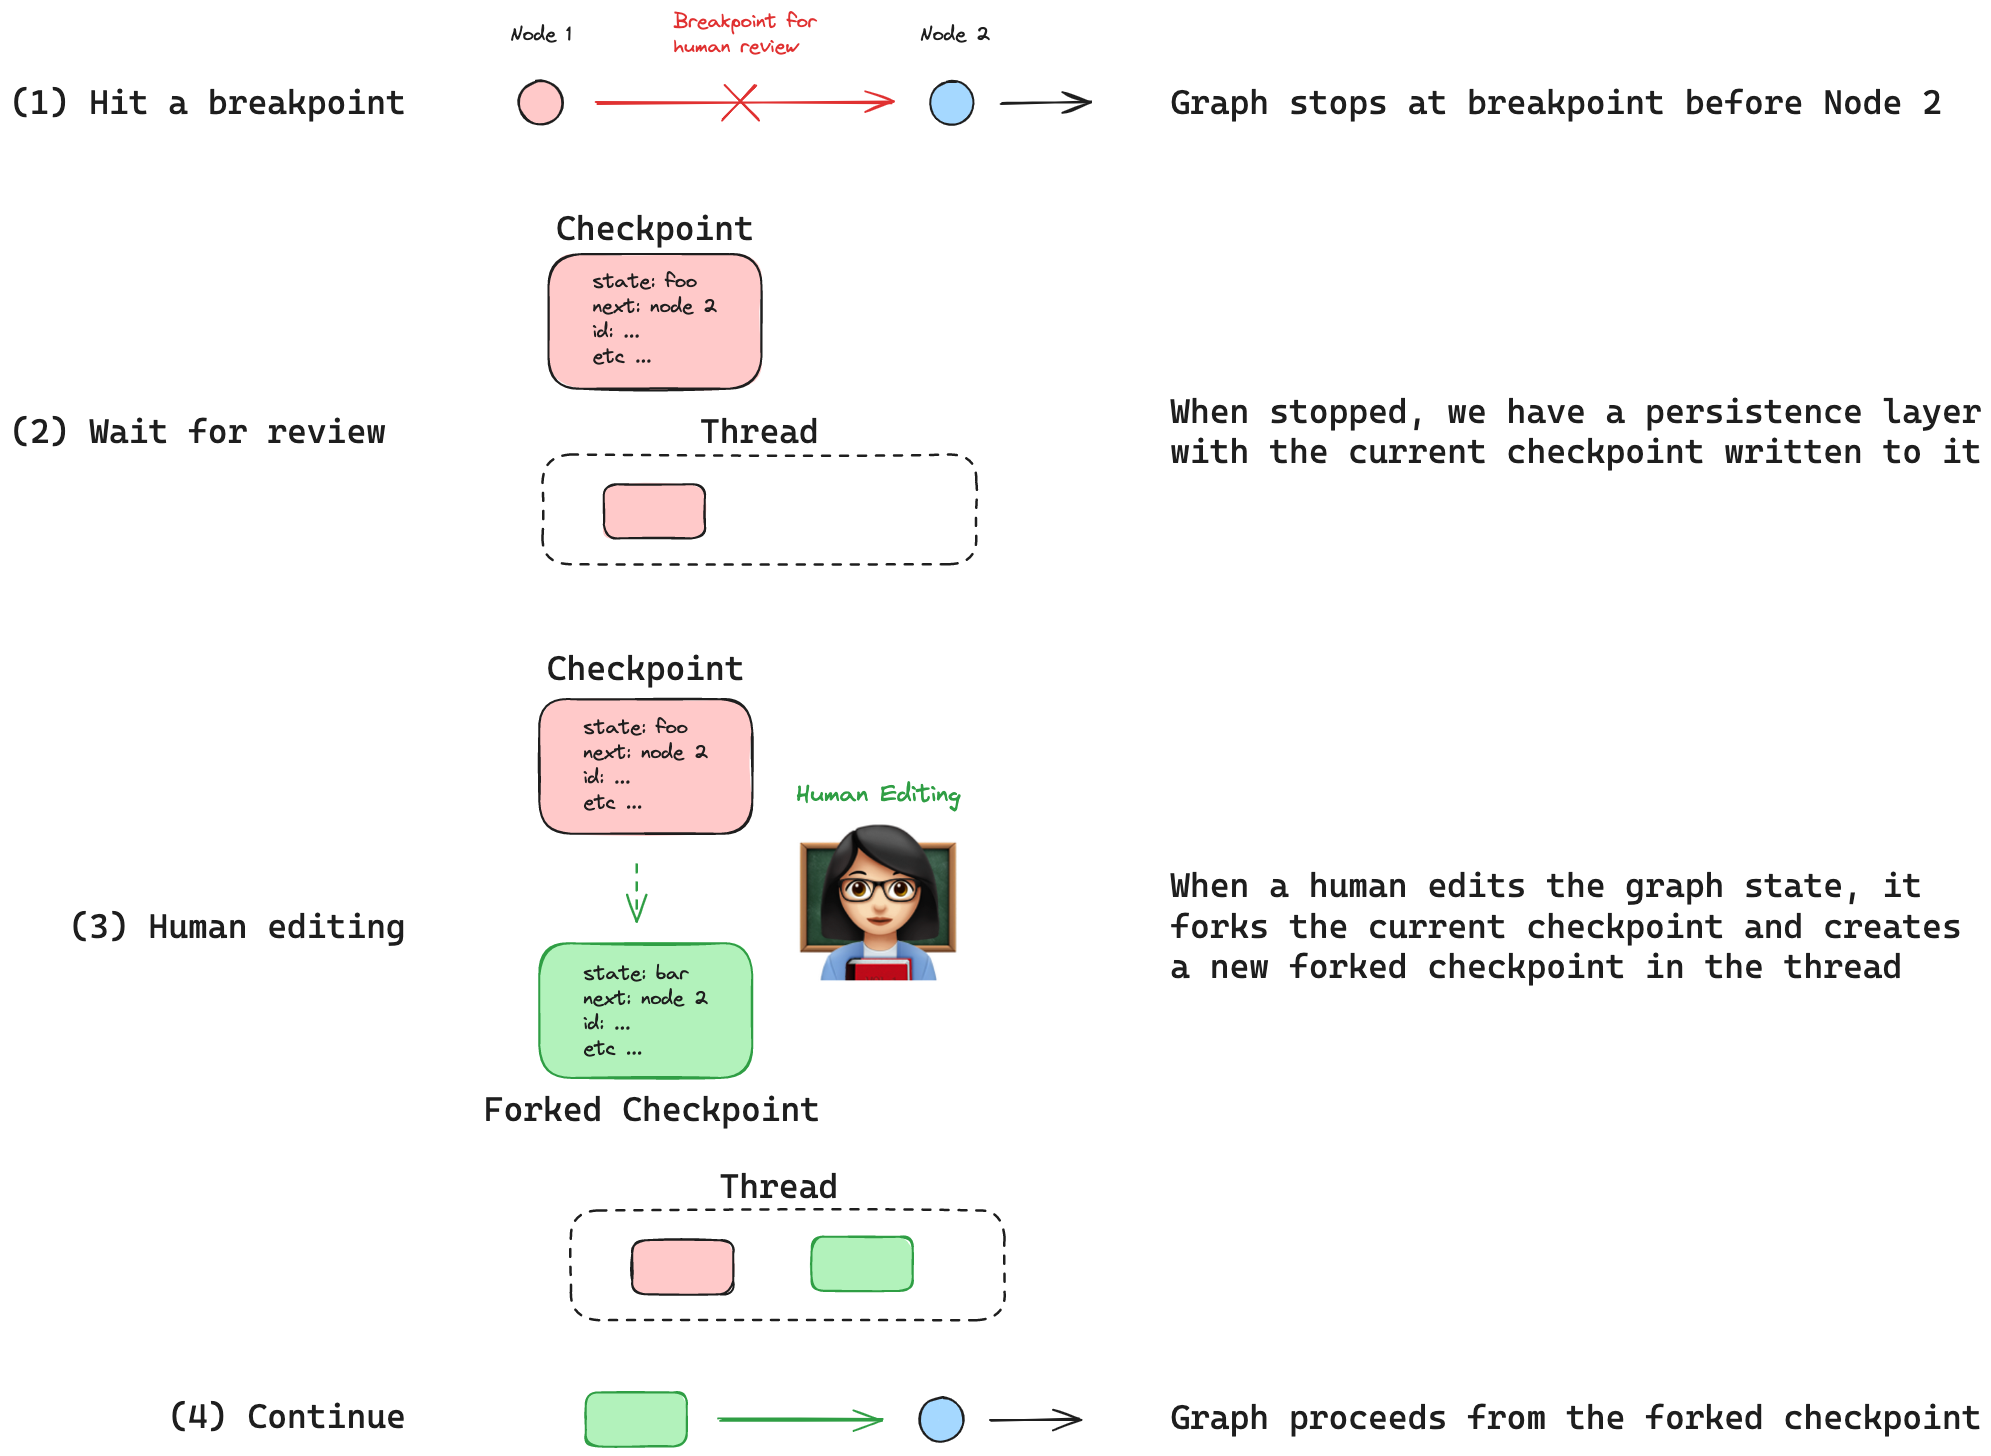

## Setup

First we need to install the packages required

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_anthropic

Next, we need to set API keys for Anthropic (the LLM we will use)

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Simple Usage

Let's look at very basic usage of this.

Below, we do three things:

1) We specify the [breakpoint](https://langchain-ai.github.io/langgraph/concepts/low_level/#breakpoints) using `interrupt_before` a specified step (node).

2) We set up a [checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer) to save the state of the graph up until this node.

3) We use `.update_state` to update the state of the graph.

In [ ]:
import uuid
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.test_redis import RedisSaver
from IPython.display import Image, display

# Set up Redis connection
REDIS_URI = "redis://redis:6379"
memory = None
with RedisSaver.from_conn_string(REDIS_URI) as cp:
    cp.setup()
    memory = cp


class State(TypedDict):
    input: str


def step_1(state):
    print("---Step 1---")
    pass


def step_2(state):
    print("---Step 2---")
    pass


def step_3(state):
    print("---Step 3---")
    pass


builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# Add
graph = builder.compile(checkpointer=memory, interrupt_before=["step_2"])

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
import uuid

# Input
initial_input = {"input": "hello world"}

# Thread - use a unique ID to avoid conflicts
thread = {"configurable": {"thread_id": str(uuid.uuid4())}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    print(event)

Now, we can just manually update our graph state - 

In [ ]:
print("Current state!")
print(graph.get_state(thread).values)

graph.update_state(thread, {"input": "hello universe!"})

print("---\n---\nUpdated state!")
print(graph.get_state(thread).values)

In [ ]:
# Continue the graph execution from the interruption point
for event in graph.stream(None, thread, stream_mode="values"):
    print(event)
print("---Step 2---")
print("---Step 3---")

## Agent

In the context of agents, updating state is useful for things like editing tool calls.
 
To show this, we will build a relatively simple ReAct-style agent that does tool calling. 

We will use Anthropic's models and a fake tool (just for demo purposes).

In [ ]:
# Set up the tool
from langchain_anthropic import ChatAnthropic
from langchain_core.tools import tool
from langgraph.graph import MessagesState, START, END, StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.test_redis import RedisSaver


@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    return [
        "It's sunny in San Francisco, but you better look out if you're a Gemini 😈."
    ]


tools = [search]
tool_node = ToolNode(tools)

# Set up the model

model = ChatAnthropic(model="claude-3-5-sonnet-20240620")
model = model.bind_tools(tools)


# Define nodes and conditional edges


# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define a new graph
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Set up Redis connection
REDIS_URI = "redis://redis:6379"
memory = None
with RedisSaver.from_conn_string(REDIS_URI) as cp:
    cp.setup()
    memory = cp

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable

# We add in `interrupt_before=["action"]`
# This will add a breakpoint before the `action` node is called
app = workflow.compile(checkpointer=memory, interrupt_before=["action"])

## Interacting with the Agent

We can now interact with the agent and see that it stops before calling a tool.

!!! tip "Thread Management"
    When running examples multiple times, it's important to use unique thread IDs to avoid conflicts with previous runs. 
    This is especially important when working with tool calls, as some LLM providers (like Anthropic) require proper 
    message history with matching tool_use and tool_result pairs. Using `uuid.uuid4()` ensures each run gets a fresh state.

In [ ]:
from langchain_core.messages import HumanMessage
import uuid

# Use a unique thread ID to avoid conflicts with previous runs
thread = {"configurable": {"thread_id": str(uuid.uuid4())}}
inputs = [HumanMessage(content="search for the weather in sf now")]

# Run until the interrupt (before the action node)
for event in app.stream({"messages": inputs}, thread, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

**Edit**

We can now update the state accordingly. Let's modify the tool call to have the query `"current weather in SF"`.

**Important**: When editing tool calls before they are executed, we need to update the message properly to maintain valid message history.

In [ ]:
# Get the current state
current_state = app.get_state(thread)

# Get the last message which contains the tool call
last_message = current_state.values["messages"][-1]
print("Original tool call:")
print(last_message.tool_calls[0])

# Create a new message with the edited tool call
# We need to create a new AIMessage with the modified tool call
from langchain_core.messages import AIMessage

edited_message = AIMessage(
    content=last_message.content,
    tool_calls=[{
        "name": last_message.tool_calls[0]["name"],
        "args": {"query": "current weather in SF"},  # Modified query
        "id": last_message.tool_calls[0]["id"],  # Keep the same ID
        "type": "tool_use"
    }],
    id=last_message.id  # Keep the same message ID for proper update
)

# Update the state with the edited message
# The message will be updated based on its ID
app.update_state(thread, {"messages": [edited_message]})

print("\nUpdated tool call:")
print(app.get_state(thread).values["messages"][-1].tool_calls[0])

Let's now check the current state of the app to make sure it got updated accordingly

In [ ]:
# Verify the update worked
current_state = app.get_state(thread)
print("Tool calls after update:")
print(current_state.values["messages"][-1].tool_calls)

**Resume**

We can now call the agent again with no inputs to continue, ie. run the tool as requested. We can see from the logs that it passes in the update args to the tool.

In [ ]:
# Resume execution - the tool will be called with the updated arguments
for event in app.stream(None, thread, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()